# INSEE income data - User validation 

In [2]:
import twitter_profile_predictor as tpp

import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import ast

ModuleNotFoundError: No module named 'twitter_profile_predictor'

### Using Tim's data

In [3]:
# # Load the data

# path = '/home/livtollanes/NewData/coordinates/dim_X/'
# file = '/m1_dimx_users_bios.csv'
# m1_bios = pd.read_csv(path+file, index_col=0)


# If the job titles have already been collected
path = '/home/livtollanes/NewData/professions/'
file = 'm1_professions.csv'
m1_bios = pd.read_csv(path+file, index_col=0)


In [9]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
m1_bios[['projection', 'screen_name', 'description_cleantext']].tail(80)

,projection,screen_name,description_cleantext
114999,-2.374537,vsylvestre85,"J ai 15 ans collegien, au college Jean Deconinck"
115000,-2.374537,DiafFarid,Mes tweets n'engagent que moi!
115001,-2.374537,e_lemeur01,Je parle de vélo et de mon FC Lorient
115002,-2.377410,FrMstk_aurelM,supporter du fcsm ps4 cod
115003,-2.379934,Districtfoot37,Compte officiel du District d'Indre-et-Loire de football (37)
115004,-2.380722,PierrotDLT,"Le jour où les cons voleront, tu seras chef d'escadrille."
115005,-2.381205,RooohMain,"PSG, Tenons nous unis PSG, Ici c'est ParisTous ensemble le coeur a jamaisRouge & Bleu Pour le PSG"
115006,-2.382454,Twittofoot,En direct du canapé !
115007,-2.382608,VTransler,Compte officiel de l'entraîneur Valentin TranslerBEF Coach U18 R1Responsable U11UF Mâconnais
115008,-2.385056,AnOriantDaViken,Twitter du groupe An Oriant Da Viken de Facebook groupe de supporter du FC Lorient


In [4]:
#analyser = tpp.df_bios_analyzer(m1_bios, description_column= 'description_cleantext')
#analyser.get_all(mainfrench='True')
#analyser.get_PCSgroup()


analyser = tpp.df_bios_analyzer(m1_bios, description_column= 'description_cleantext')
analyser.get_prostatus()

# #write to csv to avoid rerunning every time
# m1_bios.to_csv('/home/livtollanes/NewData/professions/m1_professions.csv')

In [7]:
#Select only rows where professions is not an empty list
m1_bios_professions = m1_bios[m1_bios['professions'].apply(lambda x: x != "[]")] #removing 87 183 rows

m1_bios_professions.shape #27896
#m1_bios.shape #115 079

(27896, 21)

In [26]:
#Filter the DataFrame to only include the users with one title only
m1_single_jobs = m1_bios_professions.loc[m1_bios_professions['professions'].apply(lambda x: len(ast.literal_eval(x)) == 1)]

#Make the format normal style
m1_single_jobs['professions'] = m1_single_jobs['professions'].apply(lambda x: ast.literal_eval(x)[0])
m1_single_jobs['PCSgroup'] = m1_single_jobs['PCSgroup'].apply(lambda x: ast.literal_eval(x)[0])


/tmp/ipykernel_2903710/2755774420.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m1_single_jobs['professions'] = m1_single_jobs['professions'].apply(lambda x: ast.literal_eval(x)[0])
/tmp/ipykernel_2903710/2755774420.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m1_single_jobs['PCSgroup'] = m1_single_jobs['PCSgroup'].apply(lambda x: ast.literal_eval(x)[0])


In [40]:
#Inspection of specifc job  titles/columns
col = 'blogger'  # replace with the value you're interested in
m1_single_jobs.loc[m1_single_jobs['professions'].apply(lambda x: x == col)].iloc[:, 4:].head()

,projection,screen_name,description_cleantext,tokens,bi_tokens,full_tokens,professions,prostatus,actorstatus,groupstatus,universitystatus,allstatus,age,gender,topic,lang,PCSgroup
217,1.791862,LnArnal,Blogueuse de sciences @Sciences_Cinema et vidéaste derrière @SGeantes et sur @LnArnal@piaille.fr,"['blogueuse', 'sciences', 'sciencescinema', 'vidéaste', 'derrière', 'sgeantes', 'lnarnalpiaillefr']","[('blogueuse', 'sciences'), ('sciences', 'sciencescinema'), ('sciencescinema', 'vidéaste'), ('vidéaste', 'derrière'), ('derrière', 'sgeantes'), ('sgeantes', 'lnarnalpiaillefr')]","['blogueuse', 'sciences', 'sciencescinema', 'vidéaste', 'derrière', 'sgeantes', 'lnarnalpiaillefr', ('blogueuse', 'sciences'), ('sciences', 'sciencescinema'), ('sciencescinema', 'vidéaste'), ('vidéaste', 'derrière'), ('derrière', 'sgeantes'), ('sgeantes', 'lnarnalpiaillefr')]",blogger,[],[],[],[],[],[],['Woman'],['sciences'],fr,"Information, arts and entertainment professions"
1289,1.576307,B_fournier,Directeur associé Duneconsulting - Directeur stratégie et développement Theteamschool #blogueuse #Communication #Branding #Conseil #Ens sup #France #Espagne,"['directeur', 'associé', 'duneconsulting', 'directeur', 'stratégie', 'développement', 'theteamschool', 'blogueuse', 'communication', 'branding', 'conseil', 'ens', 'sup', 'france', 'espagne']","[('directeur', 'associé'), ('associé', 'duneconsulting'), ('duneconsulting', 'directeur'), ('directeur', 'stratégie'), ('stratégie', 'développement'), ('développement', 'theteamschool'), ('theteamschool', 'blogueuse'), ('blogueuse', 'communication'), ('communication', 'branding'), ('branding', 'conseil'), ('conseil', 'ens'), ('ens', 'sup'), ('sup', 'france'), ('france', 'espagne')]","['directeur', 'associé', 'duneconsulting', 'directeur', 'stratégie', 'développement', 'theteamschool', 'blogueuse', 'communication', 'branding', 'conseil', 'ens', 'sup', 'france', 'espagne', ('directeur', 'associé'), ('associé', 'duneconsulting'), ('duneconsulting', 'directeur'), ('directeur', 'stratégie'), ('stratégie', 'développement'), ('développement', 'theteamschool'), ('theteamschool', 'blogueuse'), ('blogueuse', 'communication'), ('communication', 'branding'), ('branding', 'conseil'), ('conseil', 'ens'), ('ens', 'sup'), ('sup', 'france'), ('france', 'espagne')]",blogger,[director],[],[],[],"['deputy director', 'director']",[],['Woman'],"['strategy', 'development', 'communication']",fr,"Information, arts and entertainment professions"
1523,1.536624,CHERAZOU,#digitalmum #culture #art #éducation #banque #finance #DigitalBanking #bddf #RSE #CM #blogueuse #RédactriceWeb #entreprenariat #teamentrepreneur #i4EmploiR,"['digitalmum', 'culture', 'art', 'éducation', 'banque', 'finance', 'digitalbanking', 'bddf', 'rse', 'cm', 'blogueuse', 'rédactriceweb', 'entreprenariat', 'teamentrepreneur', 'i4emploir']","[('digitalmum', 'culture'), ('culture', 'art'), ('art', 'éducation'), ('éducation', 'banque'), ('banque', 'finance'), ('finance', 'digitalbanking'), ('digitalbanking', 'bddf'), ('bddf', 'rse'), ('rse', 'cm'), ('cm', 'blogueuse'), ('blogueuse', 'rédactriceweb'), ('rédactriceweb', 'entreprenariat'), ('entreprenariat', 'teamentrepreneur'), ('teamentrepreneur', 'i4emploir')]","['digitalmum', 'culture', 'art', 'éducation', 'banque', 'finance', 'digitalbanking', 'bddf', 'rse', 'cm', 'blogueuse', 'rédactriceweb', 'entreprenariat', 'teamentrepreneur', 'i4emploir', ('digitalmum', 'culture'), ('culture', 'art'), ('art', 'éducation'), ('éducation', 'banque'), ('banque', 'finance'), ('finance', 'digitalbanking'), ('digitalbanking', 'bddf'), ('bddf', 'rse'), ('rse', 'cm'), ('cm', 'blogueuse'), ('blogueuse', 'rédactriceweb'), ('rédactriceweb', 'entreprenariat'), ('entreprenariat', 'teamentrepreneur'), ('teamentrepreneur', 'i4emploir')]",blogger,[],[],[],[],[],[],['Woman'],"['education', 'finance', 'culture']",fr,"Information, arts and entertainment professions"
6644,0.907052,Twitizel,Blogueur élevé en plein air depuis 2004...,"['blogueur', 'élevé', 'ple

In [52]:
m1_single_jobs['professions'].unique #we have 51 unique, single job titles 

<bound method Series.unique of 9                                ['ceo']
12                   ['human resources']
17                   ['human resources']
26                          ['engineer']
46                        ['researcher']
50                           ['analyst']
57            ['communications manager']
78            ['communications manager']
82                        ['consultant']
83                         ['professor']
87                 ['community manager']
97            ['communications manager']
102                  ['human resources']
104                  ['project manager']
107                  ['mission manager']
108                       ['accountant']
114                            ['actor']
115                  ['human resources']
119                  ['human resources']
122                            ['actor']
125                  ['human resources']
133                       ['consultant']
137                  ['mission manager']
139                       

#Income test

In [80]:
#load income data
path = '/home/livtollanes/10.jan-thesis/labeldata/'
file = 'grov_rett.csv'
dtypes = {'income_mois': 'float'}
income = pd.read_csv(path+file, sep=',', dtype=dtypes)

income = income.rename(columns={'data_job_titles': 'professions'})

income['income_mois'] = income['income_mois'].dropna()

income_bios = income_bios = pd.merge(m1_single_jobs, income[['professions', 'income_mois']], on='professions', how='left')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


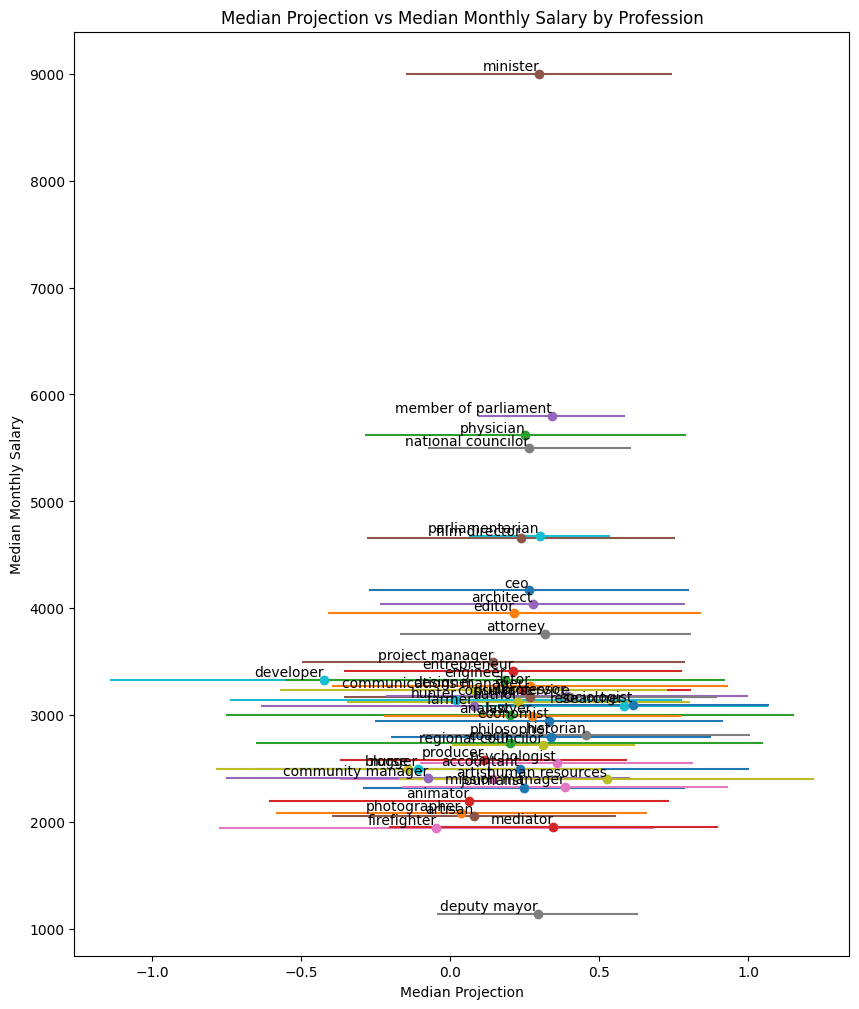

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the median of 'projection', its standard deviation, and median of 'income_mois' for each job group
grouped = income_bios.groupby('professions').agg({'projection': ['median', 'std'], 'income_mois': 'median'}).reset_index()

# Sort the jobs by median projection
grouped = grouped.sort_values(('projection', 'median'))

plt.figure(figsize=(10, 12))  # Increase the height of the figure

# Plot error bars for each job with a small random jitter added to the y-coordinates
for i in range(grouped.shape[0]):
    jitter = np.random.uniform(-0.3, 0.3)  # adjust the range as needed
    plt.errorbar(x=grouped[('projection', 'median')][i], 
                 y=grouped[('income_mois', 'median')][i] + jitter, 
                 xerr=grouped[('projection', 'std')][i], 
                 fmt='o')

# Add job labels to each point
for i in range(grouped.shape[0]):
    plt.text(grouped[('projection', 'median')][i], 
             grouped[('income_mois', 'median')][i], 
             grouped['professions'][i], 
             ha = 'right', va = 'bottom')

plt.xlabel('Median Projection')
plt.ylabel('Median Monthly Salary')
plt.title('Median Projection vs Median Monthly Salary by Profession')
plt.show()

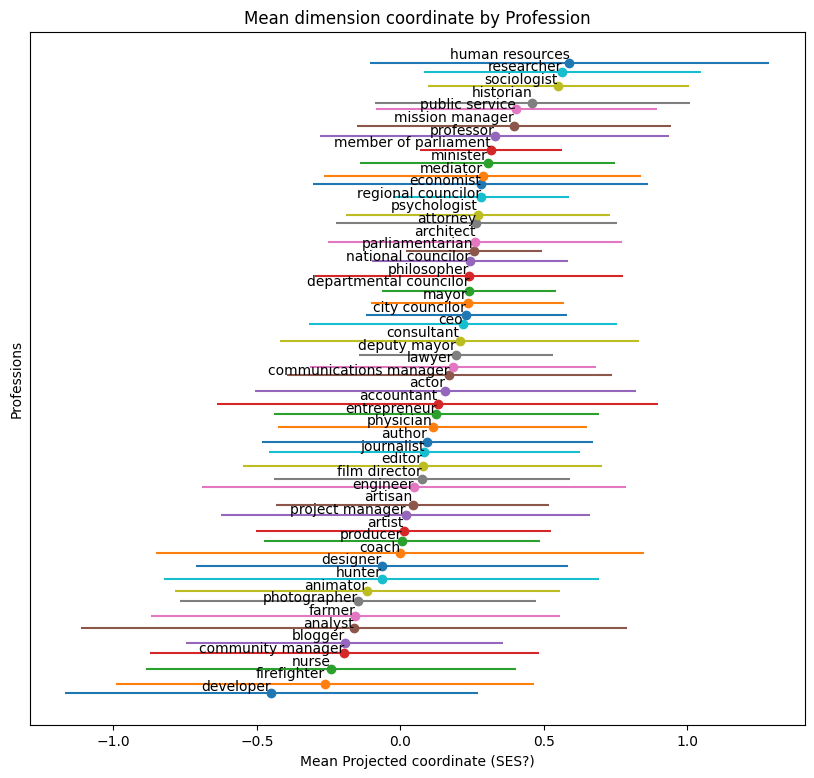

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean of 'projection' and its standard deviation for each job group
grouped = income_bios.groupby('professions').agg({'projection': ['mean', 'std']}).reset_index()

# Sort the jobs by mean projection and reset index
grouped = grouped.sort_values(('projection', 'mean')).reset_index(drop=True)
plt.figure(figsize=(10, 9))  # Adjust the size of the figure

# Plot error bars for each job with a small random jitter added to the y-coordinates
for i in range(grouped.shape[0]):
    jitter = np.random.uniform(-0.3, 0.3)  # adjust the range as needed
    plt.errorbar(x=grouped[('projection', 'mean')][i], 
                 y=i + jitter, 
                 xerr=grouped[('projection', 'std')][i], 
                 fmt='o')

# Add job labels to each point
for i in range(grouped.shape[0]):
    plt.text(grouped[('projection', 'mean')][i], 
             i, 
             grouped['professions'][i], 
             ha = 'right', va = 'bottom')

plt.xlabel('Mean Projected coordinate (SES?)')
plt.ylabel('Professions')
plt.title('Mean dimension coordinate by Profession')

# Remove y-axis numbers
plt.yticks([])

plt.show()

### New income validation approach

In [1]:
import numpy as np
import os
import matplotlib
import pandas as pd

import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter
import importlib

import sys
# Local application imports
sys.path.insert(0, '../Utility files')
import utils2
from utils2 import *

In [2]:
# # Load the data

path = '/home/livtollanes/NewData/coordinates/dim_X/'
file = '/m1_dimx_users_bios.csv'
m1_bios = pd.read_csv(path+file, index_col=0)

In [3]:
#Sort the df from high to low according to the first dimenion
m1_bios_sorted = m1_bios.sort_values(by='0', ascending=False)
#m1_bios_sorted['follower_id'].nunique() #115079

,follower_id,0,1,2,projection,screen_name,description_cleantext
115078,1056110047,2.373287,1.304695,-2.393023,-2.761358,Skunkinh0,L'humilié c'est le charme d'un homme La timidi...
115077,785463278977839104,2.341063,1.305582,-2.380031,-2.727126,masterdiete,le cheat meal le meilleur des reconfort apres ...
115076,1251551779,2.309714,1.263744,-2.292223,-2.679998,Oxygene_tango,WebRadio officielle du @stadelavallois // htt...
115075,1430233254016307200,2.301663,1.264603,-2.292688,-2.672192,JulieDfco21,Fan du rc Lens et du Dfco CM: @100_DFCO_NEWS
115074,3503654182,2.276890,1.233403,-2.291264,-2.649039,SportsValeurs,Partageons les bonnes pratiques du sports ! Su...


#### N-gram + frequency analysis

In [9]:
importlib.reload(utils2)
# Usage:
all_descriptions = ' '.join(m1_bios_sorted['description_cleantext'])
ngram_freq = utils2.get_ngram_freq(all_descriptions,n=1)


# Get the most common bigrams
#most_common_unigrams = ngram_freq.most_common(4000)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/livtollanes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
#Write the ngrams to csv
# importlib.reload(utils2)
# utils2.write_ngrams_to_csv(most_common_unigrams, 'unigrams.csv')
# utils2.write_ngrams_to_csv(most_common_bigrams, 'bigrams.csv')
# utils2.write_ngrams_to_csv(most_common_trigrams, 'trigrams.csv')
# utils2.write_ngrams_to_csv(unigrams_last1000, 'uni_last1000.csv')

In [18]:
#Load the final N-gram file
path = '/home/livtollanes/10.jan-thesis/Code/Brand Validation/'
file = 'lønn_jobbtitler.csv'
n_grams = pd.read_csv(path+file, header=0)

#rename columns
n_grams = n_grams.rename(columns={'n_gram': 'token', 'ngram': 'n'})

n_grams = n_grams.sort_values('token')


In [19]:
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import nltk
import re
from nltk.corpus import stopwords

#Add n_grams to the data frame
nltk.download('stopwords')
stop_words = set(stopwords.words('french'))

def process_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Replace hashtags and mentions with just the word
    text = re.sub(r'[@#](\w+)', r'\1', text)
    # Tokenize the string into words
    words = nltk.word_tokenize(text)
    # Remove punctuation and convert to lower case
    words = [word.lower() for word in words if word.isalpha()]
    # Remove French stopwords
    words = [word for word in words if word not in stop_words]
    return words

def get_ngrams(words, n):
    # Create ngrams
    ngram_list = list(ngrams(words, n))
    return ngram_list

m1_bios_sorted['description_cleantext_tokens'] = m1_bios_sorted['description_cleantext'].apply(process_text)

# Apply the get_ngrams function for n=1, 2, 3
for n in range(1, 4):
    m1_bios_sorted[f'ngrams_{n}'] = m1_bios_sorted['description_cleantext_tokens'].apply(lambda x: get_ngrams(x, n))

# Combine the ngrams
m1_bios_sorted['n_grams'] = m1_bios_sorted[['ngrams_1', 'ngrams_2', 'ngrams_3']].apply(lambda x: x[0] + x[1] + x[2], axis=1)

# Convert n-grams from strings to tuples in order to filter based on our predefined n-gram list
n_grams['n_gram'] = n_grams['token'].apply(lambda x: tuple(x.split()))


# Get the list of n-grams from the n_grams DataFrame
ngram_list = n_grams['n_gram'].tolist()

# Filter the m1_bios_sorted DataFrame based on our predefined ngram list
filtered_m1_bios_sorted_test = m1_bios_sorted[m1_bios_sorted['n_grams'].apply(lambda x: any(ng in x for ng in ngram_list))]

# Add a new column 'n_grams_detected'
filtered_m1_bios_sorted_test['n_grams_detected'] = filtered_m1_bios_sorted_test['n_grams'].apply(lambda x: [ng for ng in ngram_list if ng in x])


def separate_ngrams(ngrams):
    unigrams = [gram for gram in ngrams if len(gram) == 1]
    bigrams = [gram for gram in ngrams if len(gram) == 2]
    trigrams = [gram for gram in ngrams if len(gram) == 3]
    return pd.Series([unigrams, bigrams, trigrams])

# Apply the function to the 'n_grams_detected' column
filtered_m1_bios_sorted_test[['unigrams_detected', 'bigrams_detected', 'trigrams_detected']] = filtered_m1_bios_sorted_test['n_grams_detected'].apply(separate_ngrams)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/livtollanes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipykernel_3334277/1818050919.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m1_bios_sorted['n_grams'] = m1_bios_sorted[['ngrams_1', 'ngrams_2', 'ngrams_3']].apply(lambda x: x[0] + x[1] + x[2], axis=1)
/tmp/ipykernel_3334277/1818050919.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_m1_bios_sorted_test['n_grams_detected'] = filtered_m1_bios_sorted_test['n_grams'].apply(lambda x: [ng for ng in n

In [67]:
filtered_rows = m1_bios_sorted[m1_bios_sorted['n_grams'].apply(lambda x: ('horticulteur', 'paysagiste') in x)]
pd.set_option('display.max_colwidth', None)
print(filtered_rows.shape)
filtered_rows[['projection','0', 'screen_name', 'description_cleantext', 'n_grams']].iloc[0:10]

(0, 12)


,projection,0,screen_name,description_cleantext,n_grams


In [83]:
filtered_m1_bios_sorted_test.shape #40890 detected so far



(40890, 13)

#Users that should be in group 371a Cadres d'état-major administratifs, financiers, commerciaux des grandes entreprises

fr_bourgeais: "Directeur commercial groupe @TGS_France @TGS_Avocats"

### New job filtering

In [103]:
#Load the file containing all the retrieved job titles (based on our ngrams)
path = '/home/livtollanes/10.jan-thesis/Code/Brand Validation/'
file = 'lønn_jobbtitler.csv'
job_titles = pd.read_csv(path+file, header=0)

#rename columns
job_titles = job_titles.rename(columns={'n_gram': 'token', 'ngram': 'n', 'PCS_ESE_code': 'PCS_ESE'})

#Sort job titles alphabetically and drop income axis for easier merge
job_titles = job_titles.sort_values('token')
job_titles = job_titles.drop('Salaire moyen en EQTP', axis=1)

In [104]:
#Load the income data

#private income
path = '/home/livtollanes/10.jan-thesis/Code/Brand Validation/'
file = 'private_salaries.csv'
private = pd.read_csv(path+file, sep=";")

#make the codes lower case, to match between data sets
private['PCS_ESE'] = private['PCS_ESE'].str.lower()
private = private.sort_values('Salaire moyen en EQTP')

In [105]:
#public income
path = '/home/livtollanes/10.jan-thesis/Code/Brand Validation/'
file = 'public_salaries.csv'
public = pd.read_csv(path+file, sep=";")
public['PCS_ESE'] = public['PCS_ESE'].str.lower()
public = public.sort_values('Salaire moyen en EQTP')


In [106]:
#merge the public and private income dfs
income = pd.concat([public, private], ignore_index=True)

#Sort from low to high
income = income.sort_values('Salaire moyen en EQTP')

In [107]:
#Add income to the job titles
job_titles = job_titles.merge(income[['PCS_ESE', 'Salaire moyen en EQTP']], on='PCS_ESE', how='left')

In [68]:
job_titles['PCS_ESE_name'].nunique() #72 unique PCS_ESE classes

484

In [108]:
#Get the user bios - that later wil get added income
# # Load the data

path = '/home/livtollanes/NewData/coordinates/dim_X/'
file = '/m1_dimx_users_bios.csv'
m1_bios = pd.read_csv(path+file, index_col=0)

#Sort the df according to the first dimenion
m1_bios_sorted = m1_bios.sort_values(by='0', ascending=False)

In [109]:
#Get the user bios for m7 - that later wil get added income
# # Load the data

path = '/home/livtollanes/NewData/coordinates/dim_X/'
file = '/m7_dimx_users_bios.csv'
m7_bios = pd.read_csv(path+file, index_col=0)

#Sort the df according to the first dimenion
m7_bios = m7_bios.sort_values(by='0', ascending=False)

In [110]:
#Tokenize our bios and save all tokens in a new column
importlib.reload(utils2)
nltk.download('stopwords')
stop_words = set(stopwords.words('french'))

m1_bios_sorted = utils2.tokenize_bios(m1_bios_sorted, stop_words)



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/livtollanes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [111]:
importlib.reload(utils2)
nltk.download('stopwords')
stop_words = set(stopwords.words('french'))

m7_bios = utils2.tokenize_bios(m7_bios, stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/livtollanes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [112]:
# Convert n-grams from strings to tuples in order to filter based on our predefined n-gram list
job_titles['titles'] = job_titles['token'].apply(lambda x: tuple(x.split()))

#Remove all rows where PCS_ESE is NaN
job_titles = job_titles[job_titles['PCS_ESE'].notna()]

In [113]:
# Create a list of job titles from which we will filter the bios
titles_list = job_titles['titles'].tolist()

# Include only the rows that contain n_grams in our job title list
filtered_m1_bios = m1_bios_sorted[m1_bios_sorted['total_n_grams'].apply(lambda x: any(ng in x for ng in titles_list))]
filtered_m7_bios = m7_bios[m7_bios['total_n_grams'].apply(lambda x: any(ng in x for ng in titles_list))]

# Add a new column 'n_grams_detected'
filtered_m1_bios['n_grams_detected'] = filtered_m1_bios['total_n_grams'].apply(lambda x: [ng for ng in titles_list if ng in x])
filtered_m7_bios['n_grams_detected'] = filtered_m7_bios['total_n_grams'].apply(lambda x: [ng for ng in titles_list if ng in x])


# Split the detected ngrams into their respective n size
filtered_m1_bios[['unigrams_detected', 'bigrams_detected', 'trigrams_detected']] = filtered_m1_bios['n_grams_detected'].apply(utils2.separate_ngrams)

filtered_m7_bios[['unigrams_detected', 'bigrams_detected', 'trigrams_detected']] = filtered_m7_bios['n_grams_detected'].apply(utils2.separate_ngrams)

/tmp/ipykernel_3334277/595477397.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_m1_bios['n_grams_detected'] = filtered_m1_bios['total_n_grams'].apply(lambda x: [ng for ng in titles_list if ng in x])
/tmp/ipykernel_3334277/595477397.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_m7_bios['n_grams_detected'] = filtered_m7_bios['total_n_grams'].apply(lambda x: [ng for ng in titles_list if ng in x])
/tmp/ipykernel_3334277/595477397.py:14: SettingWithCopyWarning: 
A value is trying to

In [184]:
job_titles.shape #250 job title tokens included
len(job_titles['PCS_ESE'].unique()) # 66 unique PCS_ESE codes

(250, 10)

In [118]:
filtered_m7_bios.shape #6530
filtered_m1_bios.shape # 20090

(20090, 13)

In [25]:
#do an income test with only the first title detected
bios_exploded = filtered_m1_bios_sorted_test.explode('n_grams_detected')
bios_exploded = bios_exploded.drop_duplicates(subset='follower_id', keep='first')

In [27]:
bios_exploded = bios_exploded.rename(columns={'n_grams_detected': 'titles'})

In [29]:
bios_exploded.shape #20 090 detected so far
pd.set_option('display.max_colwidth', None)
bios_exploded[['0', 'screen_name', 'description_cleantext', 'total_n_grams', 'titles', 'unigrams_detected', 'bigrams_detected', 'trigrams_detected']].iloc[30:32]


,0,screen_name,description_cleantext,total_n_grams,titles,unigrams_detected,bigrams_detected,trigrams_detected
114457,1.990280,marinnicolas_16,"Ancien Joueur Professionnel de Football , aujourd’hui Conseiller Sportif","[(ancien,), (joueur,), (professionnel,), (football,), (aujourd,), (hui,), (conseiller,), (sportif,), (ancien, joueur), (joueur, professionnel), (professionnel, football), (football, aujourd), (aujourd, hui), (hui, conseiller), (conseiller, sportif), (ancien, joueur, professionnel), (joueur, professionnel, football), (professionnel, football, aujourd), (football, aujourd, hui), (aujourd, hui, conseiller), (hui, conseiller, sportif)]","(conseiller, sportif)",[],"[(conseiller, sportif)]",[]
114707,1.989935,fabienbarbier_,Responsable Communication et Marketing // Référent RSE // Référent eFoot - @LigueFootLFO,"[(responsable,), (communication,), (marketing,), (référent,), (rse,), (référent,), (efoot,), (liguefootlfo,), (responsable, communication), (communication, marketing), (marketing, référent), (référent, rse), (rse, référent), (référent, efoot), (efoot, liguefootlfo), (responsable, communication, marketing), (communication, marketing, référent), (marketing, référent, rse), (référent, rse, référent), (rse, référent, efoot), (référent, efoot, liguefootlfo)]","(responsable, communication)",[],"[(responsable, communication)]",[]


In [30]:

bios_exploded = bios_exploded.merge(job_titles, on='titles', how='left')

In [31]:
#local changes in df
bios_exploded.loc[bios_exploded['token'] == 'graphiste', 'PCS_ESE'] = '354a'
bios_exploded.loc[bios_exploded['token'] == 'graphiste', 'PCS_ESE_name'] = 'Artistes plasticiens'
bios_exploded.loc[bios_exploded['token'] == 'graphiste', 'Salaire moyen en EQTP'] = 2900

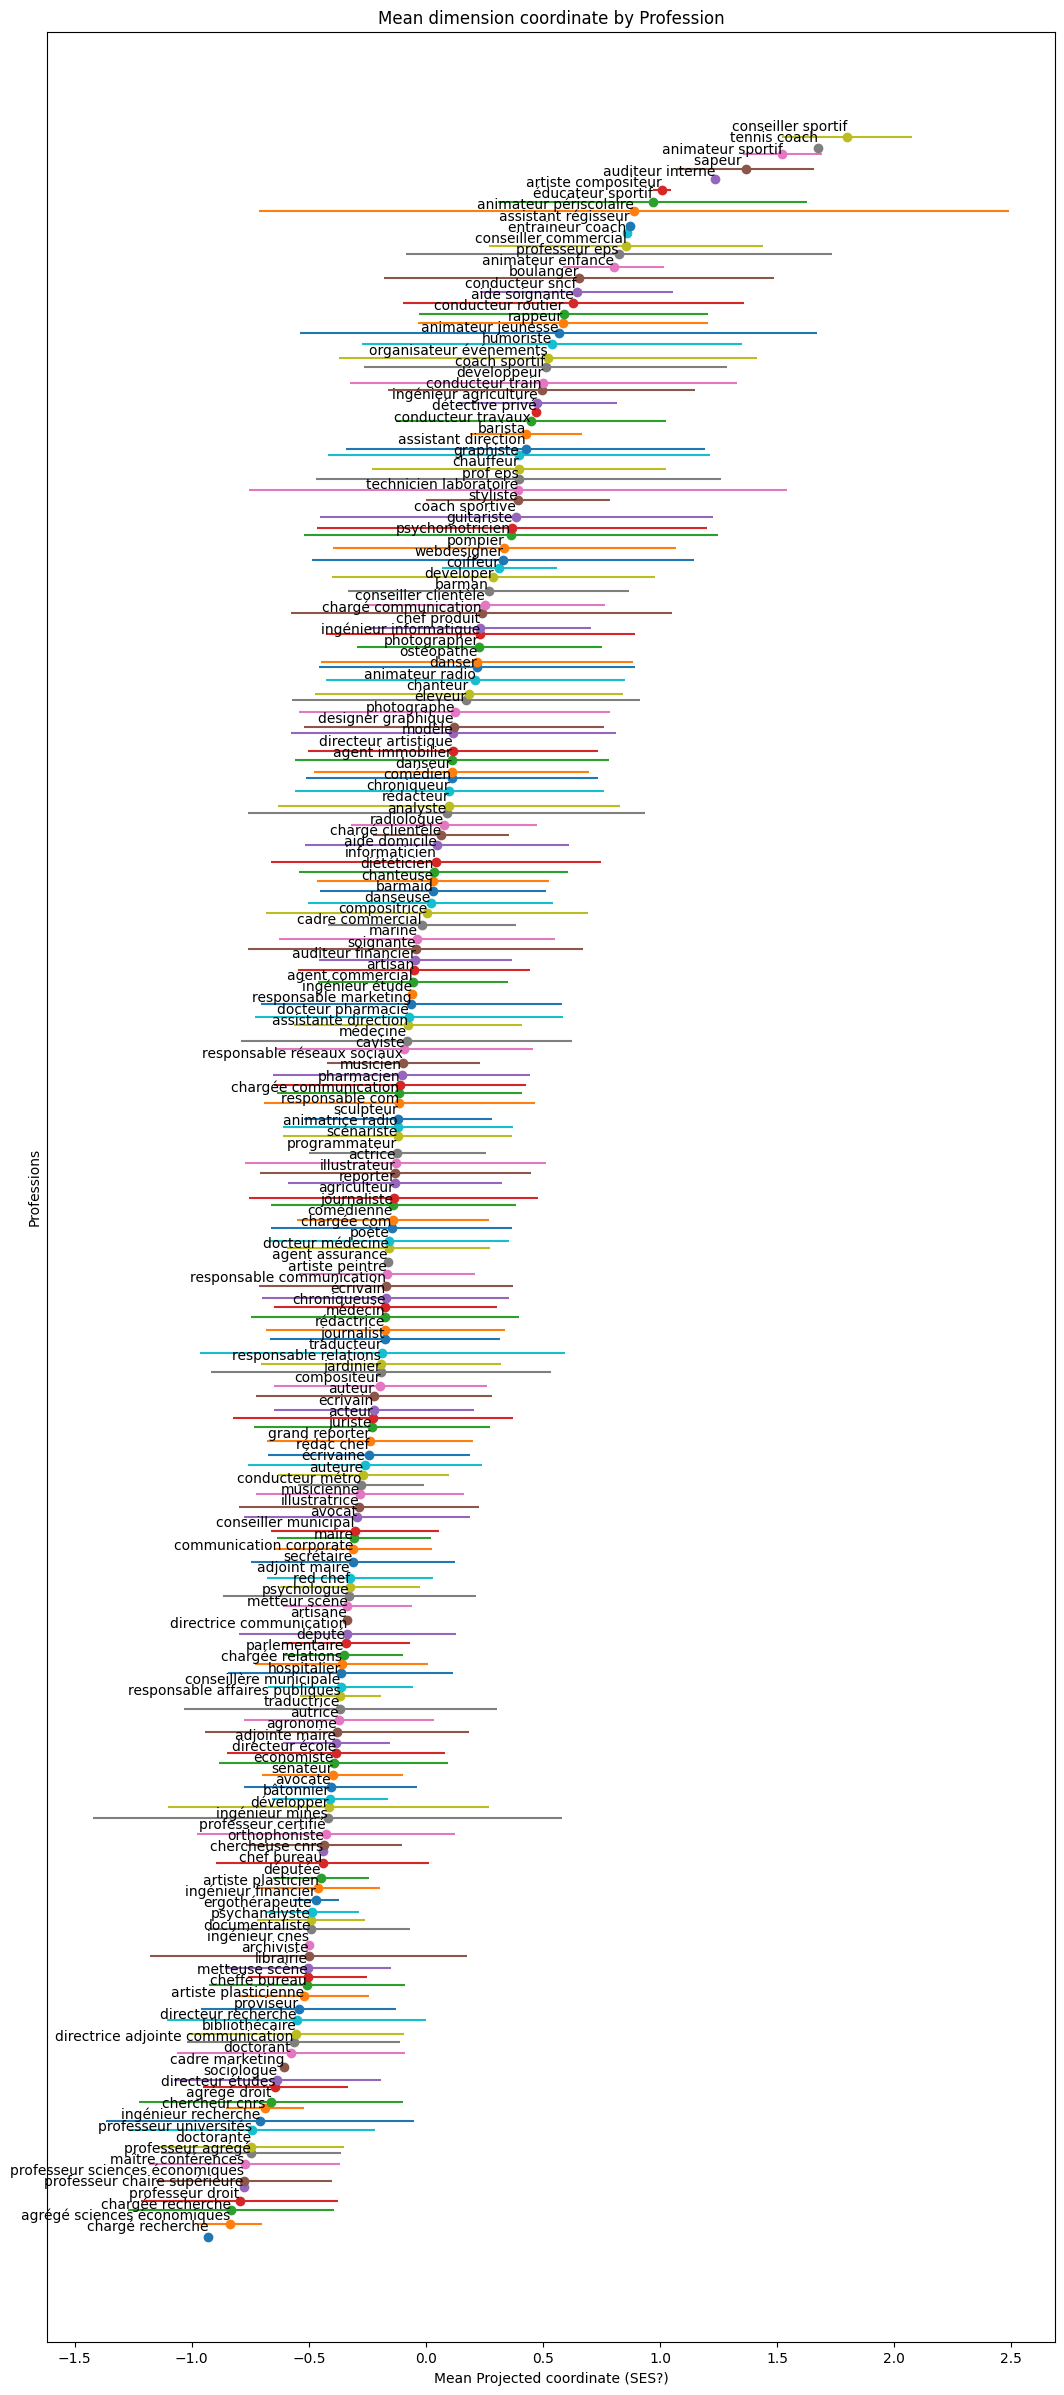

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean of 'projection' and its standard deviation for each job group
grouped = bios_exploded.groupby('token').agg({'0': ['mean', 'std']}).reset_index()

# Sort the jobs by mean projection and reset index
grouped = grouped.sort_values(('0', 'mean')).reset_index(drop=True)
plt.figure(figsize=(13, 30))  # Adjust the size of the figure

# Plot error bars for each job with a small random jitter added to the y-coordinates
for i in range(grouped.shape[0]):
    jitter = np.random.uniform(-0.3, 0.3)  # adjust the range as needed
    plt.errorbar(x=grouped[('0', 'mean')][i], 
                 y=i + jitter, 
                 xerr=grouped[('0', 'std')][i], 
                 fmt='o')

# Add job labels to each point
for i in range(grouped.shape[0]):
    plt.text(grouped[('0', 'mean')][i], 
             i, 
             grouped['token'][i], 
             ha = 'right', va = 'bottom')

plt.xlabel('Mean Projected coordinate (SES?)')
plt.ylabel('Professions')
plt.title('Mean dimension coordinate by Profession')

# Remove y-axis numbers
plt.yticks([])

plt.show()

In [48]:
bios_exploded = bios_exploded.sort_values('PCS_ESE_name', ascending=False)
bios_exploded[['Salaire moyen en EQTP', 'PCS_ESE_name', 'token', '0']].tail(5)

,Salaire moyen en EQTP,PCS_ESE_name,token,0
2382,1900.0,Adjoints administratifs des collectivités locales,adjoint maire,0.507593
19091,1900.0,Adjoints administratifs des collectivités locales,adjoint maire,-0.819249
14781,1900.0,Adjoints administratifs des collectivités locales,adjointe maire,-0.479693
10570,1900.0,Adjoints administratifs des collectivités locales,adjoint maire,-0.327184
14729,1900.0,Adjoints administratifs des collectivités locales,adjointe maire,-0.476970


In [49]:
grouped = bios_exploded.groupby('PCS_ESE_name').agg({'0': ['mean', 'std']}).reset_index()

In [53]:
import numpy as np
from scipy import stats

# Group by token and calculate mean '0' value for each token
grouped = bios_exploded.groupby('token').agg({'0': np.mean}).reset_index()
grouped = grouped.dropna()
# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(grouped['0'], grouped['Salaire moyen en EQTP'])

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")

/tmp/ipykernel_3228021/950772733.py:5: FutureWarning: The provided callable <function mean at 0x7fb5282a60c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grouped = bios_exploded.groupby('token').agg({'0': np.mean}).reset_index()


KeyError: 'Salaire moyen en EQTP'

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the median of 'projection', its standard deviation, and median of 'income_mois' for each job group
grouped = bios_exploded.groupby('token').agg({'0': ['mean', 'std'], 'Salaire moyen en EQTP': 'mean'}).reset_index()

# Sort the jobs by median projection
grouped = grouped.dropna()
grouped = grouped.sort_values(('0', 'mean'))